# Control Run Analysis

Computation of the potential prognostic predictability (PPP) for metrics from the control simulation, eventually using pre-built functions in project folder. 

**Important metrics:** <br>
- SH sea ice extent/volume
- regional sea ice extent/volume
- regional NPP, PCO2, SSS, SST
- gridpoint-level fields for sea ice concentration, SST, SSS, NPP, PCO2 <-- *this is what I started with*
- sea ice edge position (latitude at which sea ice concentration drops below 15%)

**Steps:** <br>
- open dataset, including all files in control directory for specified variable
- compute climatology + rename variable (var --> var_clim)
- compute anomalies + rename variable (var --> var_anom)
- compute variance &emsp; $\sigma^{2} = \frac{\sum (X - \mu)^{2}}{N}$
- write this dataset to a NetCDF file

In [1]:
import os
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
warnings.filterwarnings("ignore", message="Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range")
warnings.filterwarnings("ignore", message="invalid value encountered in reduce")

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from cartopy import crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point

In [184]:
## compute the climatology (time mean for each month)
def compute_clim(da):
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
    
    clim = clim.rename(da.name+'_clim')
    return clim

## compute the monthly anomalies from the 300-year control runs
def compute_anom(da):
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
        
    anom = da.groupby(time+'.month') - clim
    anom = anom.rename(da.name+'_anom')
    return anom

## compute the variance
def compute_variance(da): 
    time = 'time'
    try:
        clim = da.groupby('time.month').mean(dim='time')
    except:
        time = time.upper()
        clim = da.groupby(time+'.month').mean(dim=time)
        
    anom = da.groupby(time+'.month') - clim
    
    variance = anom.groupby(time+'.month').var(dim=time)
    variance = variance.rename(da.name+'_variance')
    return variance

## compute metrics and add appropriate metadata

In [425]:
## not used anymore, see functions above
def grid_ctrl_runs(path, var):
    ds = xr.open_mfdataset(path)

    ## compute climatology
    time = 'time'
    try:
        clim = ds.groupby(time+'.month').mean(dim=time)

    except:
        time = time.upper()
        clim = ds.groupby(time+'.month').mean(dim=time)

    ## compute anomalies
    anom = ds.groupby(time+'.month') - clim

    ## rename data variables
    clim = clim.rename({var:var+'_clim'})
    var_anom = var+'_anom'
    anom = anom.rename({var:var+'_anom'})

    ## compute variance
    ## use variance operator from xarray/numpy (.var())
#     mean = anom.groupby(time+'.month').mean(dim=time)
#     dev = anom.groupby(time+'.month') - mean
#     dev2 = dev.assign(sqr = dev[var_anom]**2)
#     dev2_sum = dev2.groupby(time+'.month').sum()
#     variance = dev2_sum.assign(v=dev2_sum[var_anom] / 300)

#     variance = variance.rename({'v':var+'_variance'})
#     variance = variance.drop_vars('sqr')
#     variance = variance.drop_vars(var_anom)
    
    variance = anom.groupby('time.month').var(dim=time)
#     variance = variance.rename({var_anom:var+'_variance'})

    ## merge climatology, anomaly, and variance data with the original dataset
#     ds_metrics = ds.merge(clim, compat='override')
#     ds_metrics = ds_metrics.merge(anom, compat='override')
#     ds_metrics = ds_metrics.merge(variance, compat='override')

    ## write to a NetCDF file (where?)
#     write_path = ??
#     filename = var.upper() + 'GRID_CTRL_PPE_metrics.nc'
#     ds_metrics.to_netcdf(write_path+filename)
    
    return variance


# grid_SST_metrics = grid_ctrl_runs(path_sst, var_sst)

## Gridpoint-level Fields

In [129]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'

#### Sea Surface Temperature (SST)

In [190]:
path_sst = rootdir+subdir_ctrl+'/SST/sst_*.nc'
var_sst = 'sst'

ds_sst = xr.open_mfdataset(path_sst)

In [191]:
sst_clim = compute_clim(ds_sst[var_sst])
sst_clim.attrs['long_name'] = 'monthly SST climatology'

sst_anom = compute_anom(ds_sst[var_sst])
sst_anom.attrs['long_name'] = 'SST anomaly'

sst_variance = compute_variance(ds_sst[var_sst])
sst_variance.attrs['long_name'] = 'variance of SST anomalies'

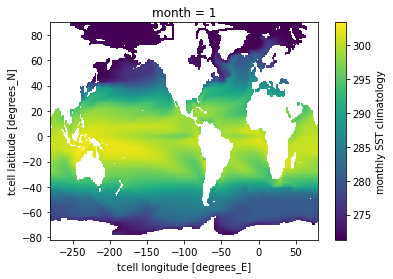

In [192]:
sst_clim[0].plot()

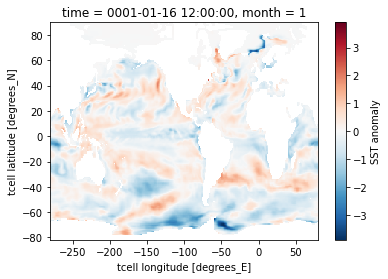

In [193]:
sst_anom[0].plot()

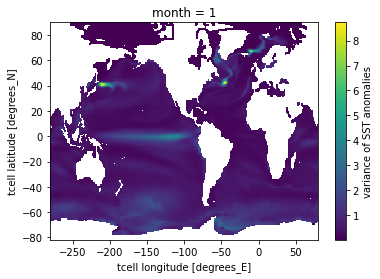

In [194]:
sst_variance[0].plot()

#### Sea Surface Salinity (SSS)

In [195]:
path_sss = rootdir+subdir_ctrl+'/SSS/sss_*.nc'
var_sss = 'sss'

ds_sss = xr.open_mfdataset(path_sss)

In [196]:
sss_clim = compute_clim(ds_sss[var_sss])
sss_clim.attrs['long_name'] = 'monthly SSS climatology'

sss_anom = compute_anom(ds_sss[var_sss])
sss_anom.attrs['long_name'] = 'SSS anomaly'

sss_variance = compute_variance(ds_sss[var_sss])
sss_variance.attrs['long_name'] = 'variance of SSS anomalies'

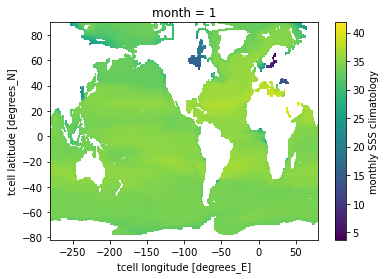

In [197]:
sss_clim[0].plot()

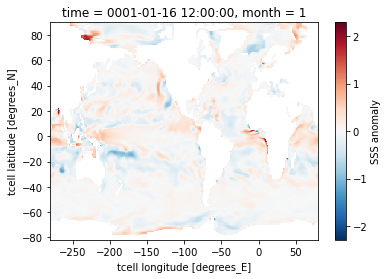

In [198]:
sss_anom[0].plot()

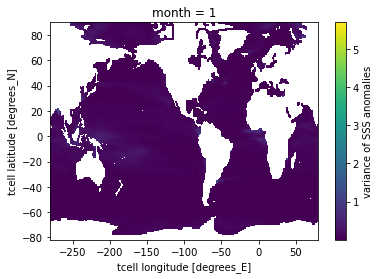

In [199]:
sss_variance[0].plot()

#### Sea-ice Concentration (CN)
Summed over all thickness categories(?)

In [243]:
path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
var_cn = 'CN_INV'

ds_cn = xr.open_mfdataset(path_cn)

In [201]:
cn_clim = compute_clim(ds_cn[var_cn])
cn_clim.attrs['long_name'] = 'monthly CN_INV climatology'

cn_anom = compute_anom(ds_cn[var_cn])
cn_anom.attrs['long_name'] = 'CN_INV anomaly'

cn_variance = compute_variance(ds_cn[var_cn])
cn_variance.attrs['long_name'] = 'variance of CN_INV anomalies'

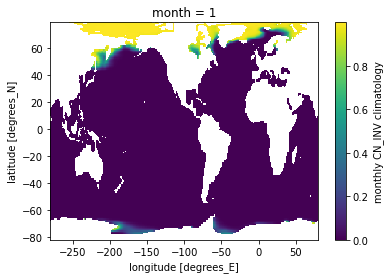

In [202]:
cn_clim[0].plot()

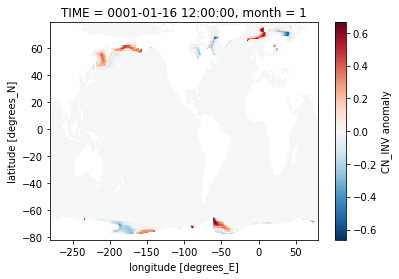

In [203]:
cn_anom[0].plot()

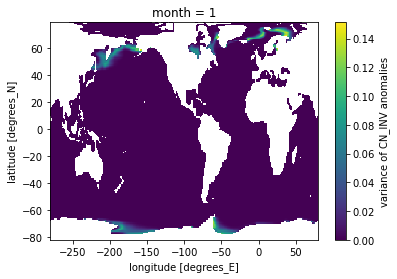

In [204]:
cn_variance[0].plot()

#### Net Primary Production (NPP)

In [205]:
path_npp = rootdir+subdir_ctrl+'/NPP/NPP_*.nc'
var_npp = 'NPP'

ds_npp = xr.open_mfdataset(path_npp)

In [206]:
npp_clim = compute_clim(ds_npp[var_npp])
npp_clim.attrs['long_name'] = 'monthly NPP climatology'

npp_anom = compute_anom(ds_npp[var_npp])
npp_anom.attrs['long_name'] = 'NPP anomaly'

npp_variance = compute_variance(ds_npp[var_npp])
npp_variance.attrs['long_name'] = 'variance of NPP anomalies'

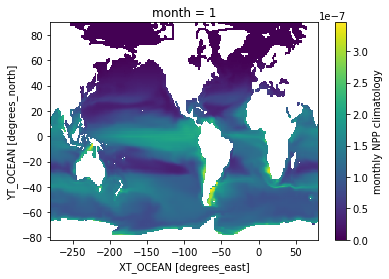

In [209]:
npp_clim[0].plot()

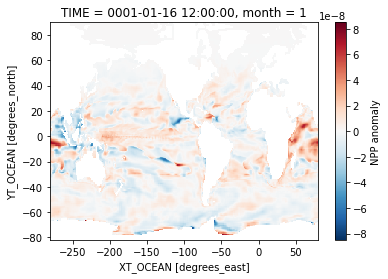

In [207]:
npp_anom[0].plot()

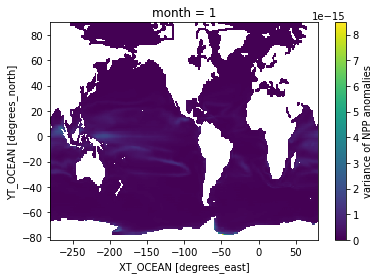

In [208]:
npp_variance[0].plot()

#### Surface pCO$_2$ (PCO2SURF)

In [210]:
path_pco2surf = rootdir+subdir_ctrl+'/PCO2SURF/pco2surf_*.nc'
var_pco2surf = 'pco2surf'

ds_pco2surf = xr.open_mfdataset(path_pco2surf)

In [212]:
pco2surf_clim = compute_clim(ds_pco2surf[var_pco2surf])
pco2surf_clim.attrs['long_name'] = 'monthly Oceanic pCO2 climatology'

pco2surf_anom = compute_anom(ds_pco2surf[var_pco2surf])
pco2surf_anom.attrs['long_name'] = 'Oceanic pCO2 anomaly'

pco2surf_variance = compute_variance(ds_pco2surf[var_pco2surf])
pco2surf_variance.attrs['long_name'] = 'variance of Oceanic pCO2 anomalies'

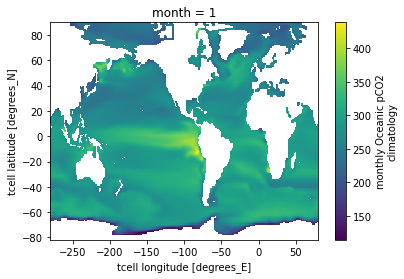

In [213]:
pco2surf_clim[0].plot()

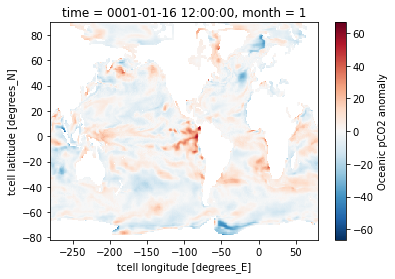

In [214]:
pco2surf_anom[0].plot()

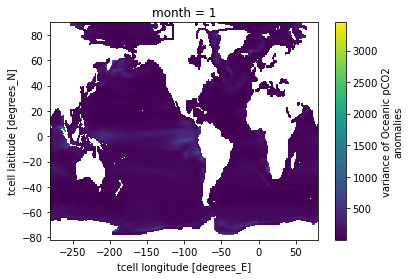

In [215]:
pco2surf_variance[0].plot()

## Southern Hemisphere Sea Ice Extent and Volume
Using sea-ice extent (EXT) and sea-ice thickness (HI) with ocean/ice model grid information.

### Sea Ice Extent

In [332]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'

In [333]:
subdir_grid = 'GRID/'

# ice_grid = xr.open_dataset(rootdir+subdir_grid+'ice_month.static.nc')
ocean_grid = xr.open_dataset(rootdir+subdir_grid+'ocean.static.nc')

In [334]:
subdir_ctrl = 'CTRL/'

path_cn = rootdir+subdir_ctrl+'/CN/CN_inv_*.nc'
cn_ds = xr.open_mfdataset(path_cn)

In [368]:
## create mask for SIE where SIC > 15%
SIE_binary = xr.where(cn_ds.CN_INV > 0.15, 1, 0)

## replace values over land with NaN
SIE_binary = xr.where(np.isnan(cn_ds.CN_INV), np.nan, SIE_binary)

## change coordinates to match ocean model grid (make compatible for areal integral)
SIE_binary = SIE_binary.rename({'XT':'xt_ocean', 'YT':'yt_ocean'})
SIE_binary = SIE_binary.assign_coords({'xt_ocean':ocean_grid.xt_ocean, 'yt_ocean':ocean_grid.yt_ocean})

## add metadata
SIE_binary.name = 'SIE_binary'
SIE_binary.attrs = {'long_name':'Sea Ice Extent (binary threshold @ >15% SIC)'}

In [420]:
SIE_area = SIE_binary * ocean_grid.area_t

SouthernOcean_mask = xr.where(SIE_area.geolat_t < -40, 1, 0)

Weddell_mask = xr.where(SIE_area.geolon_t > -60, 1, 0)
Weddell_mask = xr.where(SIE_area.geolon_t < 20, Weddell_mask, 0)
Weddell_mask = xr.where(SouthernOcean_mask > 0, Weddell_mask, 0)

Indian_mask = xr.where(SIE_area.geolon_t > 20, 1, 0)
Indian_mask = xr.where(SIE_area.geolon_t < -270, 1, Indian_mask)
Indian_mask = xr.where(SouthernOcean_mask > 0, Indian_mask, 0)

WestPacific_mask = xr.where(SIE_area.geolon_t > -270, 1, 0)
WestPacific_mask = xr.where(SIE_area.geolon_t < -160, WestPacific_mask, 0)
WestPacific_mask = xr.where(SouthernOcean_mask > 0, WestPacific_mask, 0)

Ross_mask = xr.where(SIE_area.geolon_t > -200, 1, 0)
Ross_mask = xr.where(SIE_area.geolon_t < -130, Ross_mask, 0)

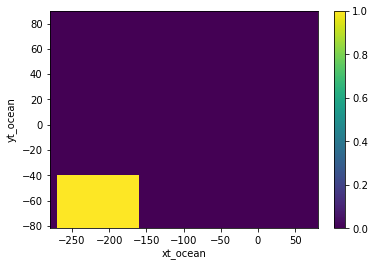

In [423]:
WestPacific_mask.plot()

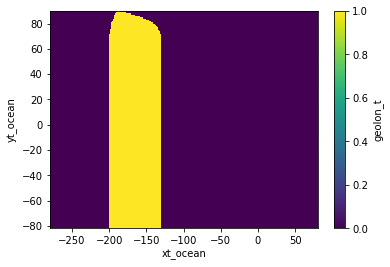

In [421]:
Ross_mask.plot()

In [424]:
# SIE_binary[0] * ice_grid.area.rename({'xt':'xt_ocean', 'yt':'yt_ocean'})

In [14]:
## get the area of sea ice
area_SIE = cn_ds.SIE_binary * ice_grid.area

## limit to just the Southern Hemisphere (for summation purposes)
SH_area_SIE = area_SIE.where(area_SIE.yt < 0)

## SIE climatology - field (values at individual grid points)
SIE_field_clim = SH_area_SIE.groupby('TIME.month').mean(dim='TIME')

## SIE anomaly - field
SIE_field_anom = SH_area_SIE.groupby('TIME.month') - SIE_field_clim

## SIE climatology - single areal sum (total area covered by sea ice in Southern Hemisphere)
SIE_sum_clim = SH_area_SIE.sum(dim={'xt', 'yt'}).groupby('TIME.month').mean(dim='TIME')

## SIE anomaly - single area sum
SIE_sum_anom = SH_area_SIE.sum(dim={'xt', 'yt'}).groupby('TIME.month') - SIE_sum_clim

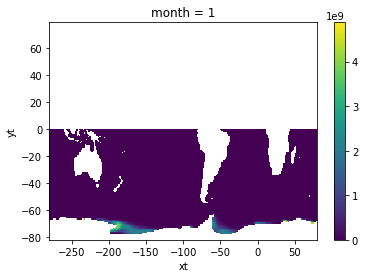

In [40]:
## value at each grid cell is area
SIE_field_clim[0].plot()

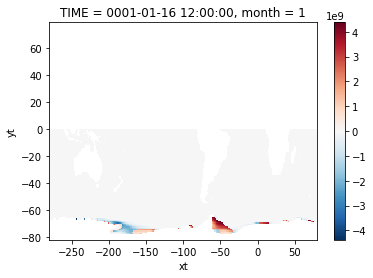

In [42]:
## value at each grid cell is area
SIE_field_anom[0].plot()

In [44]:
## total ice extent in Southern Hemisphere averaged over each month for the 300-year control simulation
SIE_sum_clim.values

array([1.14892990e+12, 2.31603328e+11, 6.33939863e+11, 2.32582982e+12,
       5.55888028e+12, 8.61559802e+12, 1.10149386e+13, 1.27361680e+13,
       1.35741690e+13, 1.34100635e+13, 1.13412775e+13, 6.12362919e+12])

In [46]:
## monthly anomalies of total ice extent in Southern Hemisphere for the 300-year control simulation
SIE_sum_anom.values

array([ 2.19515634e+11,  1.25394462e+10, -1.09077121e+11, ...,
       -2.14582805e+11, -6.06556098e+11,  4.99522225e+10])

### Sea Ice Volume
Use sea ice concentration

In [15]:
rootdir = '/local/projects/so_predict/esm2m_froelicher/'
subdir_ctrl = 'CTRL/'

path_hi = rootdir+subdir_ctrl+'/HI/HI_0001_0300.nc'
hi_ds = xr.open_mfdataset(path_hi)

hi_ds = hi_ds.rename({'time':'TIME'})

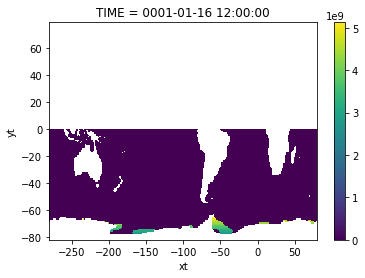

In [17]:
SH_area_SIE[0].plot()

In [18]:
SI_vol = hi_ds.HI * SH_area_SIE

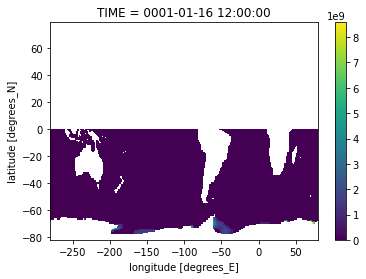

In [19]:
SI_vol[0].plot()

In [20]:
SI_vol[0].sum(dim={'xt', 'yt'}).values

array(6.39120299e+11)

In [21]:
SH_area_SIE[0].sum(dim={'xt', 'yt'}).values

array(1.36844554e+12)

**Sea ice thickness is mostly less than 1 meter in the Southern Hemisphere, so sea ice volume is less than SIC. (see below for plot of area with sea ice thickness greater than 1 meter)**

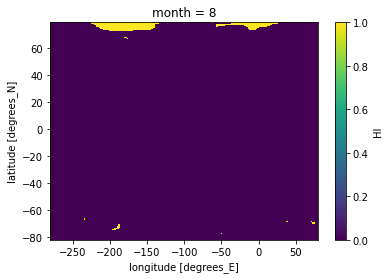

In [39]:
threshold = 1
month = 7
hi_clim = hi_ds.HI.groupby('TIME.month').mean(dim='TIME')

t = xr.where(hi_clim[month] > threshold, 1, 0)
# t = xr.where(np.isnan(hi_clim[month]), np.nan, t)
t.plot()